## Install Required Packages
Run the following commands in your terminal or command prompt to install the necessary Python packages:

```bash
pip install numpy
pip install pandas
pip install scikit-learn
pip install tensorflow
pip install openpyxl  # For reading Excel files
pip install matplotlib  # For plotting training history
```

Alternatively, install all at once:

```bash
pip install numpy pandas scikit-learn tensorflow openpyxl matplotlib
```

In [2]:
!pip install numpy pandas scikit-learn tensorflow openpyxl matplotlib


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import pickle

In [4]:
# Kyte-Doolittle Hydrophobicity Scale
hydrophobicity_scale = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8, 'G': -0.4,
    'H': -3.2, 'I': 4.5, 'K': -3.9, 'L': 3.8, 'M': 1.9, 'N': -3.5,
    'P': -1.6, 'Q': -3.5, 'R': -4.5, 'S': -0.8, 'T': -0.7, 'V': 4.2,
    'W': -0.9, 'Y': -1.3
}

# pKa values for charge calculation
pKa_values = {'N_term': 9.0, 'C_term': 2.0, 'D': 3.9, 'E': 4.3, 'H': 6.0, 'K': 10.5, 'R': 12.5}

# Disorder-promoting residues
disorder_promoting_residues = {'K', 'Q', 'S', 'E', 'P', 'A', 'G', 'D'}

# Order-promoting residues
order_promoting_residues = {'C', 'W', 'I', 'Y', 'F', 'L', 'H', 'V', 'N', 'M'}

# Updated Amino acid disorder propensity
disorder_propensity = {
    'A': 0.06, 'C': 0.02, 'D': 0.192, 'E': 0.736, 'F': -0.697, 'G': 0.166,
    'H': 0.303, 'I': -0.486, 'K': 0.586, 'L': -0.326, 'M': -0.397, 'N': 0.007,
    'P': 0.5, 'Q': 0.318, 'R': 0.180, 'S': 0.341, 'T': 0.5, 'V': -0.121,
    'W': -0.884, 'Y': -0.510
}

def henderson_hasselbalch(pKa, pH):
    return 10**(pKa - pH) / (1 + 10**(pKa - pH))

def calculate_net_charge(sequence, pH=7.4):
    charge = 0.0
    charge += henderson_hasselbalch(pKa_values['N_term'], pH)
    charge -= henderson_hasselbalch(pKa_values['C_term'], pH)
    for aa in sequence:
        if aa in pKa_values:
            if aa in ['D', 'E']:
                charge -= 1 / (1 + 10**(pKa_values[aa] - pH))
            elif aa in ['H', 'K', 'R']:
                charge += 1 / (1 + 10**(pH - pKa_values[aa]))
    return charge

def extract_features(sequence, pH=7.0):
    features = []
    for aa in sequence:
        aa_features = [
            hydrophobicity_scale.get(aa, 0),
            disorder_propensity.get(aa, 0),
            calculate_net_charge(aa, pH),
            1 if aa in disorder_promoting_residues else 0,
            1 if aa in order_promoting_residues else 0
        ]
        features.append(aa_features)
    return np.array(features)

In [5]:
# Load the Excel file
file_path = 'Original Training.xlsx'  # Replace with your actual file path
df = pd.read_excel(file_path)

# Check column names
print("Column names in the Excel file:", df.columns.tolist())

# Drop unnecessary columns
df = df[['Sequence', 'binary disorder prediction']]

# Extract sequences and labels
sequences = df['Sequence'].tolist()
labels = df['binary disorder prediction'].tolist()

# Process sequences and labels into features and targets
X = []
y = []
for seq, label in zip(sequences, labels):
    if isinstance(label, str):
        cleaned_label = ''.join(c for c in label if c in '01')
    else:
        cleaned_label = ''
        print(f"Warning: Invalid label for sequence {seq[:20]}... Skipping.")
        continue

    if len(cleaned_label) != len(seq):
        print(f"Warning: Label length ({len(cleaned_label)}) does not match sequence length ({len(seq)}) for {seq[:20]}... Skipping.")
        continue

    features = extract_features(seq)
    X.append(features)
    y.append(np.array([int(i) for i in cleaned_label]))

# Check data balance
total_residues = sum(len(l) for l in y)
ones_count = sum(sum(l) for l in y)
print(f"Total residues: {total_residues}, 1s: {ones_count}, Proportion of 1s: {ones_count / total_residues:.2f}")

# Pad sequences to the same length
max_len = max(len(seq) for seq in X)
X_padded = np.array([np.pad(x, ((0, max_len - len(x)), (0, 0)), 'constant') for x in X])
y_padded = np.array([np.pad(yi, (0, max_len - len(yi)), 'constant') for yi in y])

print(f"X shape: {X_padded.shape}, y shape: {y_padded.shape}")

Column names in the Excel file: ['Sequence', 'binary disorder prediction', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6']
Total residues: 439522, 1s: 41119, Proportion of 1s: 0.09
X shape: (532, 4128, 5), y shape: (532, 4128)


In [6]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

print(f"X_train shape: {X_train_scaled.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test_scaled.shape}, y_test shape: {y_test.shape}")

X_train shape: (425, 4128, 5), y_train shape: (425, 4128)
X_test shape: (107, 4128, 5), y_test shape: (107, 4128)


Epoch 1/100


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.8886 - loss: 0.6254 - val_accuracy: 0.9832 - val_loss: 0.2444
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.9798 - loss: 0.1591 - val_accuracy: 0.9832 - val_loss: 0.0636
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.9804 - loss: 0.0707 - val_accuracy: 0.9832 - val_loss: 0.0595
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.9815 - loss: 0.0644 - val_accuracy: 0.9832 - val_loss: 0.0570
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.9811 - loss: 0.0628 - val_accuracy: 0.9832 - val_loss: 0.0524
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.9813 - loss: 0.0549 - val_accuracy: 0.9832 - val_loss: 0.0483
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.9806 - loss: 0.0532 - val_accuracy: 0.9833 - val_loss: 0.0473
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.9812 - loss: 0.0500 - val_accuracy: 0.9833 - val_loss: 0.0

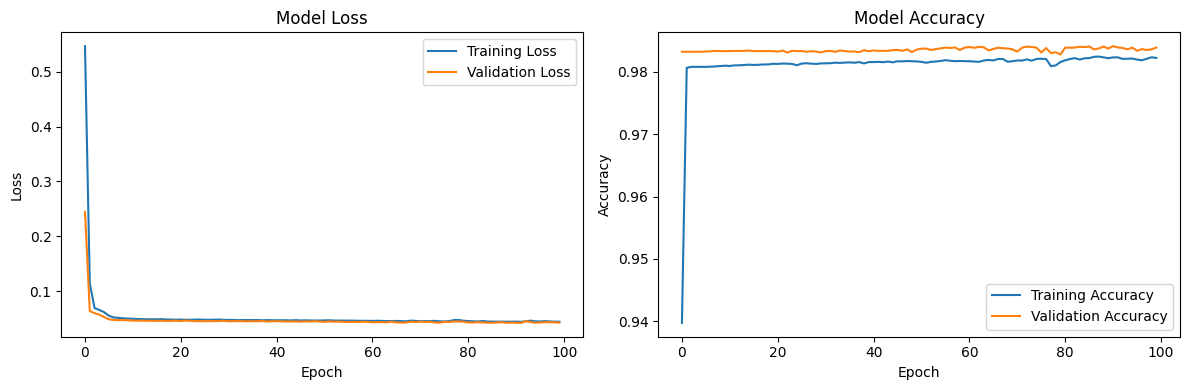

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 4128, 256)      │       268,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4128, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 4128, 128)      │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4128, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4128, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4128, 1)        │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,421,189 (5.42 MB)

 Trainable params: 473,729 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 947,460 (3.61 MB)

In [8]:
# Define the LSTM model
model = Sequential([
    LSTM(256, input_shape=(max_len, 5), return_sequences=True),
    Dropout(0.4),
    LSTM(128, return_sequences=True),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=16, validation_data=(X_test_scaled, y_test))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Summary of the model
model.summary()

In [7]:
# Save the model in .pkl format
with open('disorder_prediction_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the processed data
with open('processed_data.pkl', 'wb') as f:
    pickle.dump({'X_train': X_train_scaled, 'X_test': X_test_scaled, 'y_train': y_train, 'y_test': y_test}, f)

print("Model and data saved successfully in .pkl format.")

NameError: name 'model' is not defined

In [9]:
def predict_disorder(sequence, model, scaler, max_len, threshold=0.25):
    features = extract_features(sequence)
    features_padded = np.pad(features, ((0, max_len - len(features)), (0, 0)), 'constant')
    features_scaled = scaler.transform(features_padded.reshape(-1, features_padded.shape[-1])).reshape(1, *features_padded.shape)
    prediction = model.predict(features_scaled)[0]
    binary_prediction = (prediction > threshold).astype(int).flatten()
    binary_prediction = binary_prediction[:len(sequence)]
    print(f"Raw probabilities (first 10): {prediction[:10].flatten()}")
    print(f"Using threshold: {threshold}")
    return binary_prediction

# Prompt user for input sequence
test_sequence = input("Enter a protein sequence (using A-Z amino acid letters): ")
# Basic validation
test_sequence = test_sequence.strip().upper()
valid_aas = set('ACDEFGHIKLMNPQRSTVWY')
if not all(aa in valid_aas for aa in test_sequence):
    print("Error: Sequence contains invalid characters. Please use only A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y.")
else:
    binary_pred = predict_disorder(test_sequence, model, scaler, max_len, threshold=0.25)
    print(f"Input Sequence: {test_sequence}")
    print(f"Predicted Binary Disorder: {''.join(map(str, binary_pred))}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
Raw probabilities (first 10): [0.4193306  0.4124782  0.4246976  0.3194163  0.1708384  0.14593683
 0.15360442 0.16318406 0.17909457 0.23335177]
Using threshold: 0.25
Input Sequence: MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELLNKDFAKLGEGKHPEKLGGSAESLIPGFQSTQGDAFATTSFSAGTAEKRKGGQTVDSGLPLLSVSDPFI

In [11]:
# Load the model
with open('disorder_prediction_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Load the scaler
with open('scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

# Load the processed data
with open('processed_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

print("Model and data loaded successfully.")
print(f"Loaded X_train shape: {loaded_data['X_train'].shape}")

EOFError: Ran out of input

In [ ]:
def predict_disorder(sequence, model, scaler, max_len, threshold=0.25):
    features = extract_features(sequence)
    features_padded = np.pad(features, ((0, max_len - len(features)), (0, 0)), 'constant')
    features_scaled = scaler.transform(features_padded.reshape(-1, features_padded.shape[-1])).reshape(1, *features_padded.shape)
    prediction = model.predict(features_scaled)[0]
    binary_predic tion = (prediction > threshold).astype(int).flatten()
    binary_prediction = binary_prediction[:len(sequence)]  # Trim to sequence length
    return ''.join(map(str, binary_prediction))

# Load the input Excel file
input_file = 'input_sequences.xlsx'  # Replace with your input file path
df = pd.read_excel(input_file)

# Assume the column with sequences is named 'Sequence'
# If it's different, update the column name below
sequences = df['Sequence'].tolist()

# Determine max_len from the input sequences
max_len_input = max(len(str(seq).strip()) for seq in sequences)
# Use the greater of the training max_len and input max_len
max_len = max(max_len, max_len_input)  # Ensure max_len accommodates all sequences

# Validate sequences and predict disorder
results = []
valid_aas = set('ACDEFGHIKLMNPQRSTVWY')
for seq in sequences:
    seq = str(seq).strip().upper()  # Convert to string and clean
    if not all(aa in valid_aas for aa in seq):
        print(f"Warning: Invalid sequence detected: {seq[:20]}... Skipping.")
        results.append({'Sequence': seq, 'Predicted Binary Disorder': 'Invalid sequence'})
    else:
        binary_pred = predict_disorder(seq, model, scaler, max_len, threshold=0.25)
        results.append({'Sequence': seq, 'Predicted Binary Disorder': binary_pred})

# Create a DataFrame with results
output_df = pd.DataFrame(results)

# Save to a new Excel file
output_file = 'predicted_disorder_output.xlsx'
output_df.to_excel(output_file, index=False)
print(f"Predictions saved to {output_file}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619

In [13]:
#Our Model vs Original Values Validation

import pandas as pd
import numpy as np

def compare_binary_outputs(file1_path, file2_path):
    try:
        # Read the Excel files
        df1 = pd.read_excel(file1_path)
        df2 = pd.read_excel(file2_path)

        # Verify both files have the required columns
        required_columns = ['Sequence', 'Binary Predictions']  # Note: using 'Binary Predictions' as in your example
        if not all(col in df1.columns for col in required_columns) or \
           not all(col in df2.columns for col in required_columns):
            raise ValueError("Both files must contain 'Sequence' and 'Binary Predictions' columns")

        # Merge dataframes on Sequence column
        merged_df = pd.merge(df1, df2,
                           on='Sequence',
                           suffixes=('_file1', '_file2'))

        # Function to calculate bit-by-bit accuracy between two binary strings
        def bit_accuracy(bin1, bin2):
            if len(str(bin1)) != len(str(bin2)):
                raise ValueError(f"Binary strings length mismatch: {bin1} vs {bin2}")
            matches = sum(a == b for a, b in zip(str(bin1), str(bin2)))
            total_bits = len(str(bin1))
            return (matches / total_bits) * 100

        # Calculate individual accuracies for each sequence
        individual_accuracies = []
        for index, row in merged_df.iterrows():
            acc = bit_accuracy(row['Binary Predictions_file1'],  # Fixed column name
                             row['Binary Predictions_file2'])    # Fixed column name
            individual_accuracies.append(acc)

        # Convert to series for easier handling
        individual_accuracies = pd.Series(individual_accuracies, index=merged_df['Sequence'])

        # Calculate average accuracy
        average_accuracy = individual_accuracies.mean()

        # Print results
        print("\nIndividual Accuracies:")
        for seq, acc in individual_accuracies.items():
            print(f"Sequence {seq}: {acc:.2f}%")

        print(f"\nAverage Accuracy: {average_accuracy:.2f}%")

        return individual_accuracies, average_accuracy

    except FileNotFoundError:
        print("One or both files could not be found")
        return None, None
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None, None

# Example usage
if __name__ == "__main__":
    # Using your provided file paths
    file1 = "Original Uniprot.xlsx"
    file2 = "Predicted_disorder_output 0.25 Threshold.xlsx"

    individual_acc, avg_acc = compare_binary_outputs(file1, file2)


Individual Accuracies:
Sequence MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELLNKDFAKLGEGKHPEKLGGSAESLIPGFQSTQGDAFATTSFSAGTAEKRKGGQTVDSGLPLLSVSDPFIPLQVPDAPEKLIEGLKSPDTSLLLPDLLPMTDPFGSTSDAVIEKADVAVESLIPGLEPPVPQRLPSQTESVTSNRTDSLTGEDSLLDCSLLSNPTTDLLEEFAPTAISAPVHKAAEDSNLISGFDVPEGSDKVAEDEFDPIPVLITKNPQGGHSRNSSGSSESSLPNLARSLLLVDQLIDL: 80.6

In [14]:
#Fldpnn vs Original disorder comparison

import pandas as pd
import numpy as np

def compare_binary_outputs(file1_path, file2_path):
    try:
        # Read the Excel files
        df1 = pd.read_excel(file1_path)
        df2 = pd.read_excel(file2_path)

        # Verify both files have the required columns
        required_columns = ['Sequence', 'Binary Predictions']
        if not all(col in df1.columns for col in required_columns) or \
           not all(col in df2.columns for col in required_columns):
            raise ValueError("Both files must contain 'Sequence' and 'Binary Predictions' columns")

        # Merge dataframes on Sequence column
        merged_df = pd.merge(df1, df2,
                           on='Sequence',
                           suffixes=('_file1', '_file2'))

        # Function to calculate bit-by-bit accuracy between two binary strings
        def bit_accuracy(bin1, bin2):
            bin1_str, bin2_str = str(bin1), str(bin2)
            len1, len2 = len(bin1_str), len(bin2_str)

            # Debug: Print lengths if they differ
            if len1 != len2:
                print(f"Length mismatch for Sequence {row['Sequence']}: "
                      f"File1 length = {len1}, File2 length = {len2}")
                # Option 1: Trim longer string to match shorter one
                min_length = min(len1, len2)
                bin1_str = bin1_str[:min_length]
                bin2_str = bin2_str[:min_length]
                print(f"Trimmed to length {min_length}")

            # Calculate matches
            matches = sum(a == b for a, b in zip(bin1_str, bin2_str))
            total_bits = len(bin1_str)
            return (matches / total_bits) * 100

        # Calculate individual accuracies for each sequence
        individual_accuracies = []
        for index, row in merged_df.iterrows():
            acc = bit_accuracy(row['Binary Predictions_file1'],
                             row['Binary Predictions_file2'])
            individual_accuracies.append(acc)

        # Convert to series for easier handling
        individual_accuracies = pd.Series(individual_accuracies, index=merged_df['Sequence'])

        # Calculate average accuracy
        average_accuracy = individual_accuracies.mean()

        # Print results
        print("\nIndividual Accuracies:")
        for seq, acc in individual_accuracies.items():
            print(f"Sequence {seq}: {acc:.2f}%")

        print(f"\nAverage Accuracy: {average_accuracy:.2f}%")

        return individual_accuracies, average_accuracy

    except FileNotFoundError:
        print("One or both files could not be found")
        return None, None
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None, None

# Example usage
if __name__ == "__main__":
    # Using your updated file paths
    file1 = "Original Uniprot.xlsx"
    file2 = "Fldpnn result.xlsx"

    individual_acc, avg_acc = compare_binary_outputs(file1, file2)

Length mismatch for Sequence MVAPWRVSVRVCLSHLRCFELRQGLSLLRPSECPRDARLCWLLLGTLPKVVSLCGDVGEGAPDVLSRRRVRCSGAAGAGPAESLPRAGPLGGVFLHLRLWLRAGALLVKFFPLLLLYPLTYLAPSVSTLWLHLLLKATETSGPTYIKLGQWASTRRDLFSEAFCAQFSKLHVRVTPHPWTHTERFLRQAFGDDWGSILSFENREPVGSGCVAQVYKAYANTAFLETDSVQRLGRASCLPPFSHTGAVGGLRELFGYLGNGRKPPENLADQSFLERLLLPKADLVGSNAGVSRAQVPGHQPEATNLISVAVKVLHPGLLAQVHMDLLLMKIGSRVLGVLPGIKWLSLPEIVEEFEKLMVQQIDLRYEAQNLEHFQVNFRNVKAVKFPTPLRPFVTREVLVETYEESVPVSSYQQAGIPVDLKRKIARLGINMLLKMIFVDNFVHADLHPGNILVQGANGLSSSQEAQLQQADICDTLVVAVPSSLCPLRLVLLDAGIVAELQAPDLRNFRAVFMAVVMGQGQRVAELILHHARASECRDVEGFKTEMAMLVTQARKNTITLEKLHVSSLLSSVFKLLMTHKVKLESNFASIVFAIMVLEGLGRSLDPKLDILEAARPFLLTGPVCPP: File1 length = 626, File2 length = 627
Trimmed to length 626
Length mismatch for Sequence MWRPVQLCHFHSALLHSRQKPWPSPAVFFRRNVRGLPPRFSSPTPLWRKVLSTAVVGAPLLLGARYVMAEAREKRRMRLVVDGMGRFGRSLKVGLQISLDYWWCTNVVLRGVEENSPGYLEVMSACHQRAADALVAGAISNGGLYVKLGQGLCSFNHLLPPEYTRTLRVLEDRALKRGFQEVDELFLEDFQALPHELFQEFDYQPIAAASLAQVHRAKLHDGTSVAVKVQYIDLRDRFDGDIHTLELLLRLVE

In [12]:
#Auc-Roc curve for the new model

# Add these imports at the top with other imports

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# After the model training and history plotting (cell_5), add this code:

# Make predictions on test set
y_pred_proba = model.predict(X_test_scaled)

# Since this is a sequence prediction task, we need to flatten the arrays
y_test_flat = y_test.flatten()
y_pred_proba_flat = y_pred_proba.flatten()

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_flat, y_pred_proba_flat)
roc_auc = auc(fpr, tpr)

# Create and save ROC curve as SVG
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Save the plot as SVG
plt.savefig('roc_curve.svg', format='svg', bbox_inches='tight')
plt.close()  # Close the figure to free memory

# Print AUC score
print(f"ROC-AUC Score: {roc_auc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
ROC-AUC Score: 0.9750
